In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d felicepollano/watermarked-not-watermarked-images
!unzip watermarked-not-watermarked-images

Streaming output truncated to the last 5000 lines.
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3535082.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3535630.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3536072.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3536235.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3536271.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3536293.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3536426.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3536516.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3539894.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3539898.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3544555.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3546189.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-354941.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3551217.jpeg 

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [51]:
# Load the training and validation datasets
batch_size = 32
img_size = (256, 256)
NUM_IMAGES = 5000

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/wm-nowm/train',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/wm-nowm/valid',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size
)


# Optional: Normalize images to range [0, 1]
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))

subset_size = NUM_IMAGES // batch_size
train_ds = train_ds.take(subset_size)
validation_ds = validation_ds.take(subset_size)


Found 24986 files belonging to 2 classes.
Found 6588 files belonging to 2 classes.


In [52]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [54]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Use binary cross-entropy for binary classification
    metrics=['accuracy']
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,103,809 (88.13 MB)

 Trainable params: 23,103,809 (88.13 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)


Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 87s 553ms/step - accuracy: 0.4905 - loss: 0.6937 - val_accuracy: 0.4970 - val_loss: 0.6933
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 87s 552ms/step - accuracy: 0.4881 - loss: 0.6935 - val_accuracy: 0.4964 - val_loss: 0.6933
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 87s 558ms/step - accuracy: 0.4859 - loss: 0.6935 - val_accuracy: 0.4964 - val_loss: 0.6932
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 90s 577ms/step - accuracy: 0.4888 - loss: 0.6934 - val_accuracy: 0.4974 - val_loss: 0.6932
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 86s 549ms/step - accuracy: 0.4904 - loss: 0.6933 - val_accuracy: 0.4964 - val_loss: 0.6932
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 87s 552ms/step - accuracy: 0.4864 - loss: 0.6933 - val_accuracy: 0.4954 - val_loss: 0.6932
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 87s 555ms/step - accuracy: 0.4872 - loss: 0.6933 - val_accuracy: 0.4964 - val_loss: 0.6932
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 86s 551ms/step - accuracy: 0.4838 - loss: 0

In [49]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(validation_ds)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5235 - loss: 0.6924
Validation Loss: 0.6925
Validation Accuracy: 0.5212


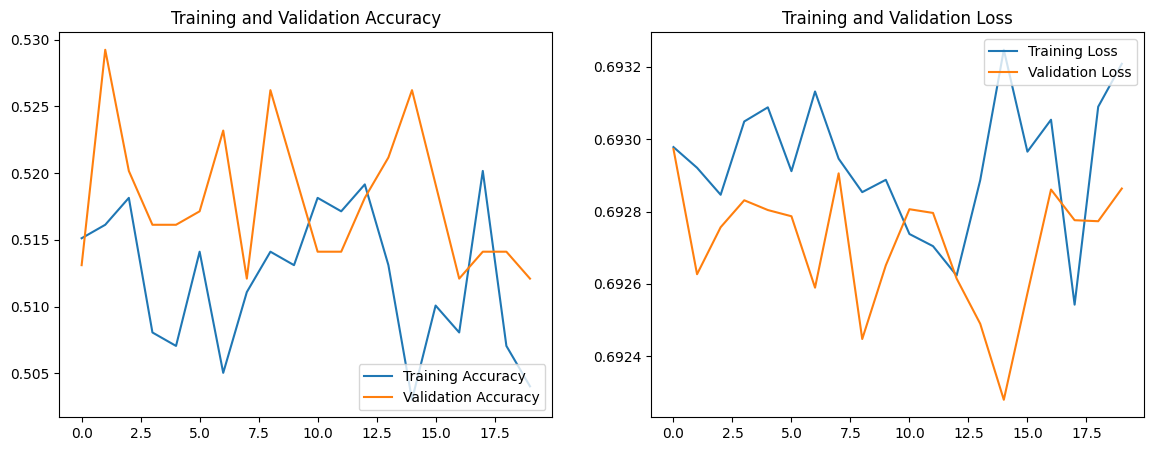

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
